In [ ]:
!pip install tf_agents
!pip install "tensorflow-probability==0.24.0"
!pip install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697739 sha256=35e73ec6060711eafa8a4ce010fbc94275bc0a57759615ec5072f738d1303815
  Stored in directory: /root/.cache/pip/wheels/bf/19/ce/d2b762b6d61115bf0b4260ca59650ba2d55d49f34f61e095f6
Successfully built gym
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6

1 GPU(s) memory-growth enabled
▶ Stage 1: training vs RANDOM opponent
 Pretrain Epoch 1: win_rate vs random = 52.5%
 Pretrain Epoch 2: win_rate vs random = 60.0%
 Pretrain Epoch 3: win_rate vs random = 61.3%
 Pretrain Epoch 4: win_rate vs random = 53.8%
  ↳ No ≥1% improvement (stagnation=1)
 Pretrain Epoch 5: win_rate vs random = 60.0%
  ↳ No ≥1% improvement (stagnation=2)
 Pretrain Epoch 6: win_rate vs random = 58.8%
  ↳ No ≥1% improvement (stagnation=3)
 ▶ Win-rate no siginificant improvement，change to MIXED！
▶ Stage 2: training vs MIXED opponent


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1: pol -0.0019, val 53.7717, ent -0.5937, win 16.2%, loss_roll10: 53.4043, win_roll10: 0.1625
Epoch 2: pol -0.0119, val 68.3387, ent -0.5210, win 20.0%, loss_roll10: 60.7654, win_roll10: 0.1813
Epoch 3: pol -0.0109, val 67.4294, ent -0.4964, win 26.2%, loss_roll10: 62.8854, win_roll10: 0.2083
Epoch 4: pol -0.0091, val 62.6574, ent -0.4634, win 17.5%, loss_roll10: 62.7347, win_roll10: 0.2000
Epoch 5: pol -0.0127, val 39.7063, ent -0.4574, win 25.0%, loss_roll10: 58.0473, win_roll10: 0.2100
Epoch 6: pol -0.0130, val 20.6610, ent -0.4575, win 20.0%, loss_roll10: 51.7429, win_roll10: 0.2083
Epoch 7: pol -0.0115, val 14.3303, ent -0.4360, win 18.8%, loss_roll10: 46.3357, win_roll10: 0.2054
Epoch 8: pol -0.0144, val 7.7823, ent -0.4345, win 21.2%, loss_roll10: 41.4611, win_roll10: 0.2062
Epoch 9: pol -0.0160, val 7.5562, ent -0.4292, win 13.8%, loss_roll10: 37.6448, win_roll10: 0.1986
Epoch 10: pol -0.0107, val 9.1368, ent -0.4346, win 18.8%, loss_roll10: 34.7497, win_roll10: 0.1975
Ep

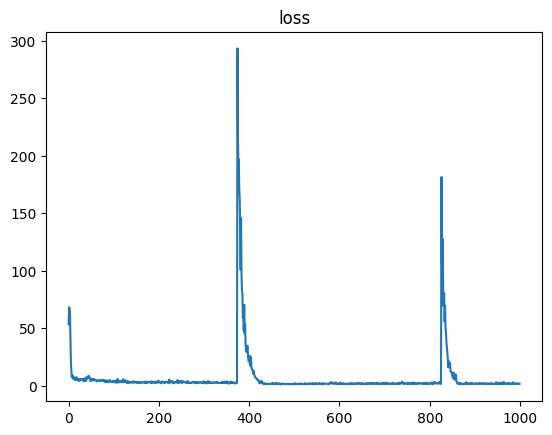

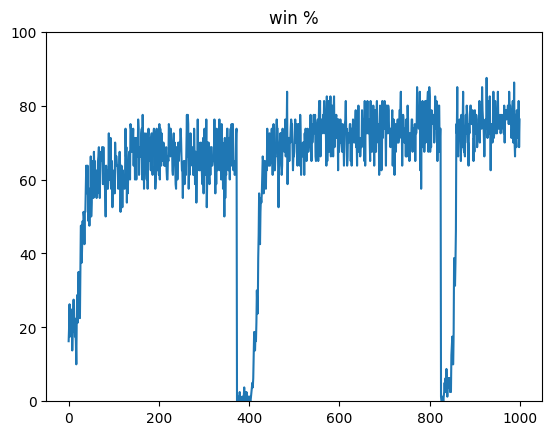

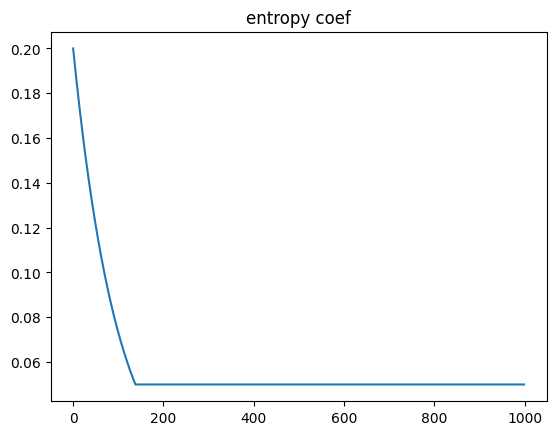


▶ Demo vs rule-based opponent


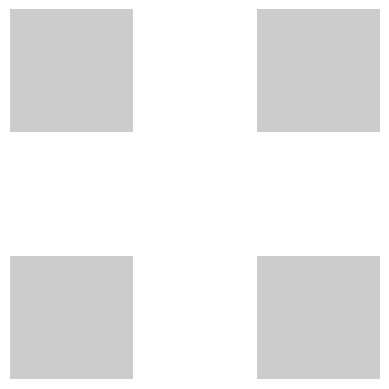

Step 01 -> (8,6)


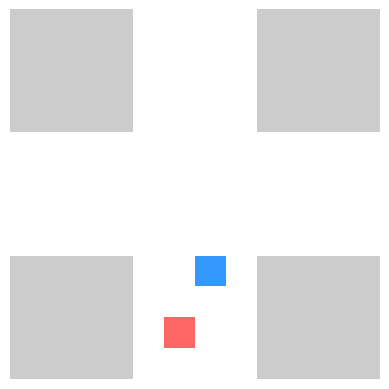

Step 02 -> (9,6)


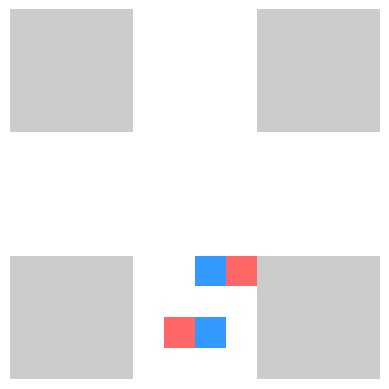

Step 03 -> (9,6)


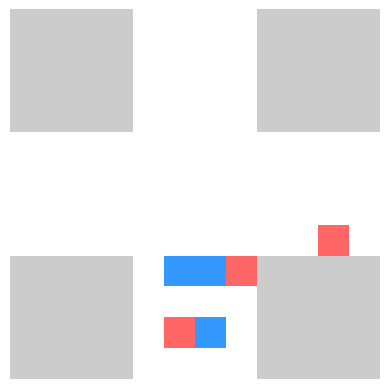

Step 04 -> (9,6)


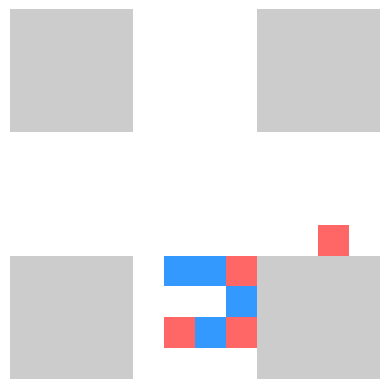

Step 05 -> (9,6)


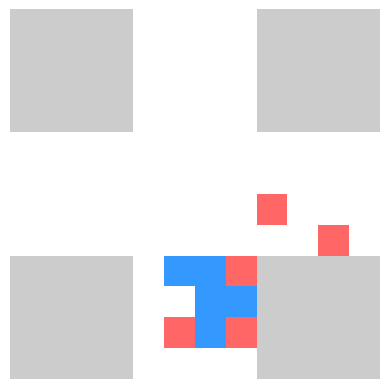

Step 06 -> (7,5)


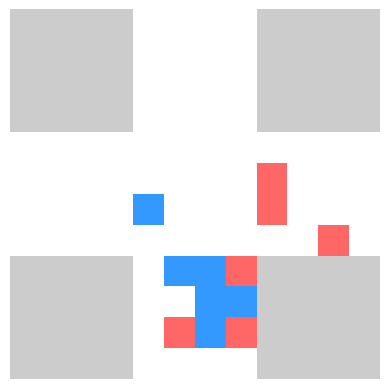

Step 07 -> (7,5)


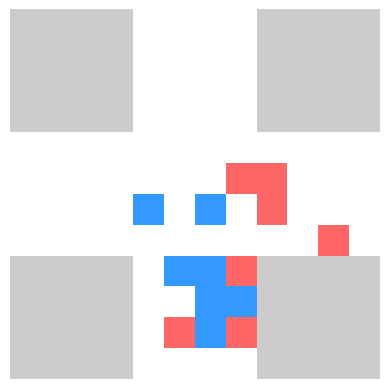

Step 08 -> (7,5)


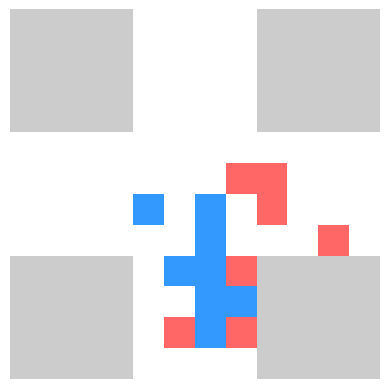

Final reward: 3.0


In [ ]:
#!/usr/bin/env python3
"""
PPO training for Super Tic-Tac-Toe with:
- legal action masking
- reward shaping
- parallel environments
- mixed opponent policies
"""

import random, time, pathlib, math
import numpy as np, matplotlib.pyplot as plt, tqdm.auto as tqdm
import tensorflow as tf, tensorflow_probability as tfp
from tf_agents.environments  import py_environment, tf_py_environment, parallel_py_environment
from tf_agents.specs         import array_spec
from tf_agents.trajectories  import time_step as ts, policy_step, from_transition
from tf_agents.networks      import network
from tf_agents.agents.ppo    import ppo_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies      import py_policy
from tf_agents.system        import multiprocessing as tf_mp
try:
    tf_mp.enable_interactive_mode()
except ValueError:
    pass
from tf_agents.policies import greedy_policy

# ─── GPU configuration ───────────────────────────────────────────────
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"{len(gpus)} GPU(s) memory-growth enabled")

# ═════════════ Board geometry and constants ══════════════════════════════
BOARD = 12
EMPTY, X, O = 0, 1, -1

# Create cross-shaped mask over 12×12 grid
CROSS = np.zeros((BOARD, BOARD), bool)
C0 = BOARD // 2 - 2
CROSS[C0:C0+4, C0:C0+4] = True
CROSS[:C0,   C0:C0+4] = True
CROSS[C0+4:, C0:C0+4] = True
CROSS[C0:C0+4, :C0]   = True
CROSS[C0:C0+4, C0+4:] = True

# Map between flat action index and board coordinates
COORDS    = [(r, c) for r in range(BOARD) for c in range(BOARD) if CROSS[r, c]]
IDX2COORD = np.array(COORDS, int)
N_CELLS   = len(COORDS)

# Eight neighbor offsets for random move distribution
NEIGH8  = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
# Precomputed linear indices for TensorFlow masking
IDX_LIN = tf.constant([r * BOARD + c for r, c in COORDS], tf.int32)

def in_bounds(r, c):
    """Check if (r, c) is within the BOARD and part of CROSS."""
    return 0 <= r < BOARD and 0 <= c < BOARD

def _count_line(board, r, c, p):
    """
    Count contiguous pieces of player p through (r,c) in 4 directions:
    horizontal, vertical, main diagonal, anti-diagonal.
    Returns list of counts for each direction.
    """
    out = []
    for dr, dc in [(0,1), (1,0), (1,1), (-1,1)]:
        cnt = 1
        # forward direction
        rr, cc = r + dr, c + dc
        while in_bounds(rr, cc) and CROSS[rr, cc] and board[rr, cc] == p:
            cnt += 1
            rr += dr; cc += dc
        # backward direction
        rr, cc = r - dr, c - dc
        while in_bounds(rr, cc) and CROSS[rr, cc] and board[rr, cc] == p:
            cnt += 1
            rr -= dr; cc -= dc
        out.append(cnt)
    return out

# ═════════════ Reward shaping constants ══════════════════════════════
SCALE       = 1.0
R_LEGAL     = 0.5    # base reward for a legal move
B_TWO       = 0.5    # bonus for making a 2-in-a-row
B_THREE     = 0.8    # bonus for making 3-in-a-row or more
R_ILLEGAL   = -1.0   # penalty for illegal move
R_PASS_EDGE = -1.0   # penalty when random adjacent picks out-of-bounds
P_NO_SPACE  = -1.0   # penalty if no empty neighbors after placement
P_IGN_THR   = -0.7   # penalty for ignoring opponent's 3-in-a-row threat

# ═════════════ Environment definition ════════════════════════════════
class SuperTicTacToe(py_environment.PyEnvironment):
    """Custom PyEnvironment for the Super Tic-Tac-Toe game."""
    def __init__(self, opponent="random"):
        """
        Initialize environment specs, opponent policies, and state.
        opponent: "random", "rule", or "mixed".
        """
        self._obs_spec = array_spec.BoundedArraySpec((BOARD, BOARD, 3), np.float32, 0, 1)
        self._act_spec = array_spec.BoundedArraySpec((), np.int32, 0, N_CELLS - 1)
        self._opp_type = opponent
        self._rnd  = RandomPolicy(self)
        self._rule = RuleBasedPolicy(self)
        self._state = None
        self._done  = False
        self._turn  = X

    def observation_spec(self):
        """Return the observation spec."""
        return self._obs_spec

    def action_spec(self):
        """Return the action spec."""
        return self._act_spec

    def _reset(self):
        """Reset the board state and turn. Return initial TimeStep."""
        self._state = np.zeros((BOARD, BOARD), np.int8)
        self._turn  = X
        self._done  = False
        return ts.restart(self._obs())

    def _step(self, action):
        """
        Apply agent move, check terminal, then apply opponent move,
        and return the appropriate TimeStep.
        """
        if self._done:
            return self.reset()

        # Agent's move
        reward = self._apply_move(action, self._turn, agent_move=True)
        done, winner = self._check_terminal()
        if done:
            return ts.termination(self._obs(), self._final_reward(winner))

        # Select opponent action
        opp_pol = self._rule if self._opp_type == "rule" else self._rnd
        if self._opp_type == "mixed":
            opp_pol = self._rule if random.random() < 0.3 else self._rnd
        opp_act = opp_pol.action(self._fake()).action

        # Opponent's move
        self._apply_move(int(opp_act), self._turn, agent_move=False)
        done, winner = self._check_terminal()
        if done:
            return ts.termination(self._obs(), self._final_reward(winner))

        # Continue with transition
        return ts.transition(self._obs(), reward, discount=1.0)

    def _apply_move(self, idx, player, agent_move=True):
        """
        Attempt to place piece for player at IDX2COORD[idx].
        With 50% chance place at target, else random empty neighbor.
        Returns shaped reward or penalty.
        """
        r, c = IDX2COORD[int(idx)]
        # Illegal: occupied or outside CROSS
        if self._state[r, c] != EMPTY or not CROSS[r, c]:
            if agent_move:
                # switch turn on illegal agent move
                self._turn = -player
                return R_ILLEGAL
            else:
                return 0.0

        # 50% chance to place at chosen spot
        if random.random() < 0.5:
            self._state[r, c] = player
            raw = self._positional_reward(r, c, player) if agent_move else 0.0
            self._turn = -player
            return raw * SCALE

        # Otherwise choose random legal neighbor
        legal = [
            (r+dr, c+dc)
            for dr, dc in NEIGH8
            if in_bounds(r+dr, c+dc)
            and CROSS[r+dr, c+dc]
            and self._state[r+dr, c+dc] == EMPTY
        ]
        if not legal:
            self._turn = -player
            return (R_PASS_EDGE * SCALE) if agent_move else 0.0

        rr, cc = random.choice(legal)
        self._state[rr, cc] = player
        raw = self._positional_reward(rr, cc, player) if agent_move else 0.0
        self._turn = -player
        return raw * SCALE

    def _positional_reward(self, r, c, p):
        """
        Compute shaped reward after placing at (r,c) by player p:
        - base legal move reward
        - bonus for 2-in-row or 3+-in-row
        - penalty if no empty neighbors
        - penalty if ignoring opponent threat
        """
        bonus = R_LEGAL

        # Bonus for creating lines
        own_lengths = _count_line(self._state, r, c, p)
        m = max(own_lengths)
        if m >= 3:
            bonus += B_THREE
        elif m == 2:
            bonus += B_TWO

        # Penalty if no empty adjacent cells
        no_space = True
        for dr, dc in NEIGH8:
            rr, cc = r + dr, c + dc
            if in_bounds(rr, cc) and CROSS[rr, cc] and self._state[rr, cc] == EMPTY:
                no_space = False
                break
        if no_space:
            bonus += P_NO_SPACE

        # Penalty if opponent has an active 3-in-row threat
        if self._opponent_threat():
            bonus += P_IGN_THR

        return bonus

    def _opponent_threat(self):
        """
        Check if opponent has any 3-in-row threat or live-2 threat
        not yet blocked on the board.
        """
        for r, c in COORDS:
            if self._state[r, c] != -self._turn:
                continue
            lengths = _count_line(self._state, r, c, -self._turn)
            if max(lengths) >= 3:
                return True
            # Live-2 horizontal threat
            if lengths[0] == 2:
                left  = (r, c-1)
                right = (r, c+1)
                if all(in_bounds(rr, cc) and CROSS[rr, cc] and self._state[rr, cc] == EMPTY
                       for rr, cc in [left, right]):
                    return True
            # Live-2 vertical threat
            if lengths[1] == 2:
                up   = (r-1, c)
                down = (r+1, c)
                if all(in_bounds(rr, cc) and CROSS[rr, cc] and self._state[rr, cc] == EMPTY
                       for rr, cc in [up, down]):
                    return True
        return False

    def _check_terminal(self):
        """
        Check if game is won or board is full.
        Returns (done_flag, winner) where winner ∈ {X, O, 0}.
        """
        for r, c in COORDS:
            p = self._state[r, c]
            if p == EMPTY:
                continue
            lengths = _count_line(self._state, r, c, p)
            # Win: 4 in row/col or 5 on diagonal
            if (max(lengths) >= 4 and any(lengths[:2])) or max(lengths) >= 5:
                return True, p
        # Draw if no empty cells
        if np.all(self._state[CROSS] != EMPTY):
            return True, 0
        return False, None

    @staticmethod
    def _final_reward(w):
        """
        Compute final reward: +3 for X win, -3 for O win, 0 for draw.
        """
        base = 3.0 if w == X else -3.0 if w == O else 0.0
        return base * SCALE

    def _obs(self):
        """
        Build observation tensor of shape (BOARD,BOARD,3):
        channel 0: X positions, channel 1: O positions,
        channel 2: current player flag.
        """
        x = (self._state == X).astype(np.float32)
        o = (self._state == O).astype(np.float32)
        p = np.full_like(x, 1.0 if self._turn == X else 0.0, np.float32)
        return np.stack([x, o, p], -1)

    def _fake(self):
        """
        Generate a fake TimeStep for opponent policy calls,
        preserving observation shape.
        """
        return ts.TimeStep(
            step_type   = np.array(1, np.int32),
            reward      = np.array(0.0, np.float32),
            discount    = np.array(1.0, np.float32),
            observation = self._obs()
        )

# ════════════ Opponent policies ════════════════════════════
class RandomPolicy(py_policy.PyPolicy):
    """Random legal-move policy for opponent."""
    def __init__(self, env):
        super().__init__(env.time_step_spec(), env.action_spec())

    def _action(self, time_step, _=()):
        """
        Choose a random empty cell from the board as action.
        """
        B = time_step.observation[..., 0] - time_step.observation[..., 1]
        legal = [i for i, (r, c) in enumerate(IDX2COORD) if B[r, c] == 0]
        return policy_step.PolicyStep(np.int32(random.choice(legal)), (), ())

class RuleBasedPolicy(py_policy.PyPolicy):
    """Greedy blocking/winning policy for opponent."""
    def __init__(self, env):
        super().__init__(env.time_step_spec(), env.action_spec())

    def _action(self, time_step, _=()):
        """
        If a winning move exists, take it; otherwise random legal.
        """
        Bx = time_step.observation[..., 0]
        Bo = time_step.observation[..., 1]
        B  = Bo - Bx
        # Check for winning move for opponent
        for idx, (r, c) in enumerate(IDX2COORD):
            if B[r, c] != 0:
                continue
            T = B.copy()
            T[r, c] = 1
            if max(_count_line(T, r, c, 1)) >= 4:
                return policy_step.PolicyStep(idx, (), ())
        # Otherwise pick random empty
        legal = [i for i, (r, c) in enumerate(IDX2COORD) if B[r, c] == 0]
        return policy_step.PolicyStep(np.int32(random.choice(legal)), (), ())

# ════════════ Actor network with legal-mask ═══════════════════════════════
def legal_mask(obs):
    """
    Compute binary mask of legal moves from observation:
    1 for empty CROSS cells, 0 otherwise.
    """
    empty = 1.0 - tf.cast(tf.reduce_max(obs[..., :2], -1), tf.float32)
    flat  = tf.reshape(empty, (tf.shape(empty)[0], BOARD * BOARD))
    return tf.gather(flat, IDX_LIN, axis=1)

class MaskedActor(network.Network):
    """
    Actor network producing a masked categorical distribution
    over N_CELLS legal actions.
    """
    def __init__(self, obs_spec, act_spec,
                 conv_params=((64,3,1),(64,3,1),(64,3,1)),
                 fc_params=(256,128)):
        super().__init__(input_tensor_spec=obs_spec, state_spec=(), name="actor")
        # Convolutional feature extractor
        self._conv  = [
            tf.keras.layers.Conv2D(filters=n, kernel_size=k, strides=s,
                                   activation='relu', padding='same')
            for n, k, s in conv_params
        ]
        self._flat  = tf.keras.layers.Flatten()
        # Fully connected layers
        self._fc    = [tf.keras.layers.Dense(units=u, activation='relu')
                       for u in fc_params]
        # Output logits for all BOARD*BOARD positions
        self._logits = tf.keras.layers.Dense(act_spec.maximum + 1)

    def call(self, obs, step_type=None, network_state=(), training=False):
        """
        Forward pass: conv -> flatten -> fc -> logits -> mask -> distribution.
        """
        bs = tf.shape(obs)[:-3]
        o  = tf.reshape(obs, (-1, BOARD, BOARD, 3))
        x  = tf.cast(o, tf.float32)
        for layer in self._conv:
            x = layer(x, training=training)
        x = self._flat(x)
        for layer in self._fc:
            x = layer(x, training=training)
        logits = self._logits(x)
        # Mask illegal actions by subtracting large constant
        mask   = legal_mask(o)
        logits = tf.where(mask > 0, logits, logits - 1e2)
        logits = tf.reshape(logits, tf.concat([bs, [N_CELLS]], axis=0))
        return tfp.distributions.Categorical(logits=logits), network_state

class SharedValue(network.Network):
    """
    Shared trunk value network using same conv+fc as actor,
    with final dense to scalar value.
    """
    def __init__(self, actor):
        super().__init__(input_tensor_spec=actor.input_tensor_spec,
                         state_spec=(), name="value")
        self._conv  = actor._conv
        self._flat  = actor._flat
        self._fc    = actor._fc
        self._v     = tf.keras.layers.Dense(1)

    def call(self, obs, step_type=None, network_state=(), training=False):
        """
        Forward pass: conv -> flatten -> fc -> single value -> squeeze.
        """
        bs = tf.shape(obs)[:-3]
        o  = tf.reshape(obs, (-1, BOARD, BOARD, 3))
        x  = tf.cast(o, tf.float32)
        for layer in self._conv:
            x = layer(x, training=training)
        x = self._flat(x)
        for layer in self._fc:
            x = layer(x, training=training)
        v = self._v(x)
        v = tf.reshape(v, tf.concat([bs, [1]], axis=0))
        return tf.squeeze(v, -1), network_state

# ───────── Hyper-parameters ─────────────────────────────────────────────
EPOCHS          = 1000
PRETRAIN_EPOCHS = 20
NUM_ENVS        = 8
COLLECT_PER_ENV = 64
EVAL_EPIS       = 80
SAVE_EVERY      = 200
TARGET_WIN      = 0.90

LR_BASE      = 1e-4
ENTROPY_INIT = 0.2
MIN_ENT_COEF = 0.05
CLIP_RATIO   = 0.30
NUM_PPO_EPOCH= 5
VALUE_COEF   = 1.5
GAE_LAMBDA   = 0.80

# ───────── Build PPO agent with shared networks ─────────────────────────
_dummy_py  = parallel_py_environment.ParallelPyEnvironment(
    [lambda: SuperTicTacToe("random")] * NUM_ENVS
)
_dummy_env = tf_py_environment.TFPyEnvironment(_dummy_py)

actor_net = MaskedActor(_dummy_env.observation_spec(),
                        _dummy_env.action_spec())
value_net = SharedValue(actor_net)

global_step = tf.Variable(0, dtype=tf.int64)
lr_sched    = tf.keras.optimizers.schedules.CosineDecay(
    LR_BASE, EPOCHS, alpha=0.1
)
entropy_coef = tf.Variable(ENTROPY_INIT, dtype=tf.float32,
                           trainable=False)

agent = ppo_agent.PPOAgent(
    time_step_spec           = _dummy_env.time_step_spec(),
    action_spec              = _dummy_env.action_spec(),
    optimizer                = tf.keras.optimizers.Adam(lr_sched),
    actor_net                = actor_net,
    value_net                = value_net,
    importance_ratio_clipping= CLIP_RATIO,
    entropy_regularization   = entropy_coef,
    value_pred_loss_coef     = VALUE_COEF,
    num_epochs               = NUM_PPO_EPOCH,
    train_step_counter       = global_step,
    normalize_rewards        = True,
    reward_norm_clipping     = 6.0,
    lambda_value             = GAE_LAMBDA,
    discount_factor          = 0.97,
    use_gae                  = True,
    use_td_lambda_return     = True,
    gradient_clipping        = 0.5,
)
agent.initialize()

# ───────── Placeholder replay buffer ─────────────────────────────────────
buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=NUM_ENVS,
    max_length=COLLECT_PER_ENV
)

# ───────── collect_steps helper ─────────────────────────────────────────
def collect_steps(env):
    """
    Collect one step of experience per parallel env and add to buffer.
    """
    t0 = env.current_time_step()
    ps = agent.collect_policy.action(t0)
    t1 = env.step(ps.action)
    done = t1.is_last().numpy()
    if np.any(done):
        env.reset()
        tr = env.current_time_step()
        # Stitch terminal transitions for done environments
        t1 = ts.TimeStep(
            step_type   = tf.where(done, tr.step_type,   t1.step_type),
            reward      = tf.where(done, tr.reward,      t1.reward),
            discount    = tf.where(done, tr.discount,    t1.discount),
            observation = tf.where(
                done[..., None, None, None],
                tr.observation,
                t1.observation
            )
        )
    buffer.add_batch(from_transition(t0, ps, t1))

# ───────── Evaluation helper ────────────────────────────────────────────
greedy_eval_policy = greedy_policy.GreedyPolicy(agent.policy)

def evaluate(env, policy, episodes=EVAL_EPIS):
    """
    Run given policy for a number of episodes and return win rate.
    """
    wins = 0
    for _ in range(episodes):
        ts0 = env.reset()
        while not ts0.is_last():
            ts0 = env.step(policy.action(ts0).action)
        wins += float(ts0.reward) > 0
    return wins / episodes

# ─────────── Stage 1: Pre-train vs RANDOM ──────────────────────────────
print("▶ Stage 1: training vs RANDOM opponent")
train_py_1    = parallel_py_environment.ParallelPyEnvironment(
    [lambda: SuperTicTacToe("random")] * NUM_ENVS
)
train_env     = tf_py_environment.TFPyEnvironment(train_py_1)
eval_env_rand = tf_py_environment.TFPyEnvironment(
    SuperTicTacToe("random")
)

prev_wr     = 0.0
stagnation  = 0
STAGNATION_LIMIT = 3     # stop if no improvement in this many epochs
MIN_IMPROVEMENT  = 0.01  # require at least 1% win-rate bump

for ep in range(PRETRAIN_EPOCHS):
    # collect experience
    for _ in range(COLLECT_PER_ENV):
        collect_steps(train_env)
    exp = buffer.gather_all()
    buffer.clear()
    agent.train(exp)

    # evaluate
    wr = evaluate(eval_env_rand, greedy_eval_policy)
    print(f" Pretrain Epoch {ep+1}: win_rate vs random = {wr*100:.1f}%")
    if wr >= prev_wr + MIN_IMPROVEMENT:
        stagnation = 0
        prev_wr = wr
    else:
        stagnation += 1
        print(f"  ↳ No ≥{MIN_IMPROVEMENT*100:.0f}% improvement (stagnation={stagnation})")
        if stagnation >= STAGNATION_LIMIT:
            print(" ▶ Win-rate no significant improvement, switching to MIXED")
            break

# ─────────── Stage 2: Main training vs MIXED ───────────────────────────
print("▶ Stage 2: training vs MIXED opponent")
train_py_2 = parallel_py_environment.ParallelPyEnvironment(
    [lambda: SuperTicTacToe("mixed")] * NUM_ENVS
)
train_env  = tf_py_environment.TFPyEnvironment(train_py_2)
eval_env   = tf_py_environment.TFPyEnvironment(SuperTicTacToe("rule"))

# rebuild buffer for stage 2
buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=NUM_ENVS,
    max_length=COLLECT_PER_ENV
)

losses, wins, entrs = [], [], []
with tqdm.tqdm(range(EPOCHS)) as bar:
    for ep in bar:
        # collect experience
        for _ in range(COLLECT_PER_ENV):
            collect_steps(train_env)

        # update entropy coefficient schedule
        new_ec = ENTROPY_INIT * (0.99 ** ep)
        new_ec = tf.maximum(new_ec, MIN_ENT_COEF)
        entropy_coef.assign(new_ec)
        entrs.append(float(entropy_coef.numpy()))

        # train agent on collected batch
        exp = buffer.gather_all()
        buffer.clear()
        loss_info = agent.train(exp)
        losses.append(float(loss_info.loss))

        # evaluate performance
        wr = evaluate(eval_env, greedy_eval_policy)
        wins.append(wr)

        # log detailed metrics
        pl = float(loss_info.extra.policy_gradient_loss)
        vl = float(loss_info.extra.value_estimation_loss)
        el = float(loss_info.extra.entropy_regularization_loss)
        print(
            f"Epoch {ep+1}: pol {pl:.4f}, val {vl:.4f}, "
            f"ent {el:.4f}, win {wr*100:4.1f}%, "
            f"loss_roll10: {sum(losses[-10:])/min(len(losses),10):.4f}, "
            f"win_roll10: {sum(wins[-10:])/min(len(wins),10):.4f}"
        )
        bar.set_postfix(loss=f"{loss_info.loss:.3f}",
                        coef=f"{entropy_coef.numpy():.2f}",
                        win=f"{wr*100:4.1f}%")
        # save checkpoints periodically
        if (ep+1) % SAVE_EVERY == 0:
            ckpt = tf.train.Checkpoint(agent=agent, step=global_step)
            manager = tf.train.CheckpointManager(ckpt, "./ppo_ttt_ckpt", max_to_keep=3)
            manager.save()
        if wr >= TARGET_WIN:
            manager.save()
            break

# ════════════ Plot training metrics ═══════════════════════════════════
plt.figure()
plt.plot(losses)
plt.title("loss")
plt.show()

plt.figure()
plt.plot(np.array(wins) * 100)
plt.title("win %")
plt.ylim(0, 100)
plt.show()

plt.figure()
plt.plot(entrs)
plt.title("entropy coef")
plt.show()

# ════════════ Demo play utilities ════════════════════════════════════
def draw_board(B):
    """
    Render current board state as a colored image.
    Blue for X, red for O, grey for empty.
    """
    img = np.ones((BOARD, BOARD, 3))
    img[~CROSS] = 0.8
    img[B == X] = [0.2, 0.6, 1.0]
    img[B == O] = [1.0, 0.4, 0.4]
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def play_and_render(policy, pause=0.3):
    """
    Play one game against rule-based opponent,
    rendering each move with a pause.
    """
    env = SuperTicTacToe("rule")
    timestep = env.reset()
    draw_board(env._state)
    time.sleep(pause)
    step_count = 0
    while not timestep.is_last():
        step_count += 1
        action = policy.action(timestep).action
        r, c = IDX2COORD[int(action)]
        print(f"Step {step_count:02d} -> ({r},{c})")
        timestep = env.step(action)
        draw_board(env._state)
        time.sleep(pause)
    print("Final reward:", float(timestep.reward))

print("\n▶ Demo vs rule-based opponent")
play_and_render(agent.policy)